In [1]:
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from graphviz import Source


## Goal
**Build out a model that helps predict which factors/variables best predict retention of players.**

Before building out a model we need to first describe a couple of things about our dataset.

- What features do we have?
- How are the fetures distributed?
- What outputs do we have?

Knowing this information is imporant, because if the data is not normally distributed then any model that we build would have trouble making sense of it

In [2]:
# Pull in the data and take a peek
df = pd.read_csv('p5_deep_dive_02.csv',encoding='utf-8')
df.head()

,event_date,user_id,platform,channel,country,total_currency_spent,max_boat_level,fishing_experience,map_location,crew_amount,0_day_retention,1_day_retention,3_day_retention,7_day_retention,14_day_retention
0,8/1/19,00000531-8500-4eb4-bf3b-64f96788a16f,ANDROID,NON-ORGANIC,Non-US,50.0,1.0,17.0,0.0,4.0,0,0,1,0,0
1,8/1/19,000011f7-5d55-477b-a720-3b60d07249ff,IOS,NaN,US,33.0,14.0,9110.0,10.0,5.0,0,0,0,0,0
2,8/1/19,000058b4-6047-4872-961e-fc89d0617ba9,ANDROID,NaN,Non-US,15.0,12.0,2759.0,9.0,6.0,0,0,0,0,0
3,8/1/19,00005be2-ba5c-442a-9180-993323205189,ANDROID,NON-ORGANIC,Non-US,5.0,6.0,554.0,3.0,4.0,0,0,0,0,0
4,8/1/19,00005c2e-5a54-410a-a919-917b8cfe98d5,ANDROID,NON-ORGANIC,Non-US,22.0,3.0,15.0,2.0,3.0,1,0,0,0,0


### Initial Look at the Data
Before we even get deep into the distribution of the data, looking at the head of the data shows that we will need to do the following:

- Decide how to deal with NaN
- Remove irrelevant columns
- Turn categorical features into a numerical (or binary) format

### Dealing with NaN
While there are several ways to deal with NaN
- COALESCE in sql
- Take the most common value and fill NaN with that value (categorical)
- Take the average or median and fill NaN with that value (numerical)

I felt as though those were out of scope for this assignment. For now we will just remove rows that have NaN / Null values.

In [3]:
df_with_nan_len = len(df)
df.dropna(inplace=True)
df_dropped_nan_len = len(df)

print('Dataset with NaN   : ', df_with_nan_len)
print('Dataset without NaN: ', df_dropped_nan_len)

Dataset with NaN   :  12200
Dataset without NaN:  5433


As you can see, this removed a large portion of our data set so I just want to emphasize that normally we would do whatever we can to be able to keep those values.

### Remove irrelevant columns
We needed `event_date` and `user_id` to pull the data, but now those will not be features that we need so we will remove them from our data frame.

In [4]:
df = df.drop(['event_date', 'user_id'], axis='columns')
df.head()

,platform,channel,country,total_currency_spent,max_boat_level,fishing_experience,map_location,crew_amount,0_day_retention,1_day_retention,3_day_retention,7_day_retention,14_day_retention
0,ANDROID,NON-ORGANIC,Non-US,50.0,1.0,17.0,0.0,4.0,0,0,1,0,0
3,ANDROID,NON-ORGANIC,Non-US,5.0,6.0,554.0,3.0,4.0,0,0,0,0,0
4,ANDROID,NON-ORGANIC,Non-US,22.0,3.0,15.0,2.0,3.0,1,0,0,0,0
5,ANDROID,NON-ORGANIC,Non-US,6.0,10.0,1691.0,7.0,1.0,0,0,0,0,0
6,IOS,NON-ORGANIC,US,19.0,10.0,4145.0,8.0,7.0,0,0,0,0,0


### Transform Features
We will need to do some transformations on our features, both categorical and numerical so we can create an array that holds the column_names for each. We can also designate the remaining columns as the targets here.

In [5]:
categorical_headers = ['channel', 'country', 'platform']
numerical_headers = ['total_currency_spent', 'max_boat_level', 'fishing_experience', 'map_location', 'crew_amount']
# Everything else is a target
target_headers = list(set(list(df.columns)) - set(list(categorical_headers)) - set(list(numerical_headers)))

### Transform Categorical features
This method will turn all categorical features into column names where the value is 1 if the row contained that feature and 0 if it did not.

In [6]:
df_n = pd.get_dummies(df, columns=categorical_headers)
df_n.head(5).columns

Index(['total_currency_spent', 'max_boat_level', 'fishing_experience',
       'map_location', 'crew_amount', '0_day_retention', '1_day_retention',
       '3_day_retention', '7_day_retention', '14_day_retention',
       'channel_NON-ORGANIC', 'channel_ORGANIC', 'country_Non-US',
       'country_US', 'platform_ANDROID', 'platform_IOS'],
      dtype='object')

### Transform Numerical features
Now before we transform the numerical features we can take a look at how our feature data is distributed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a811d50>,
      dtype=object)

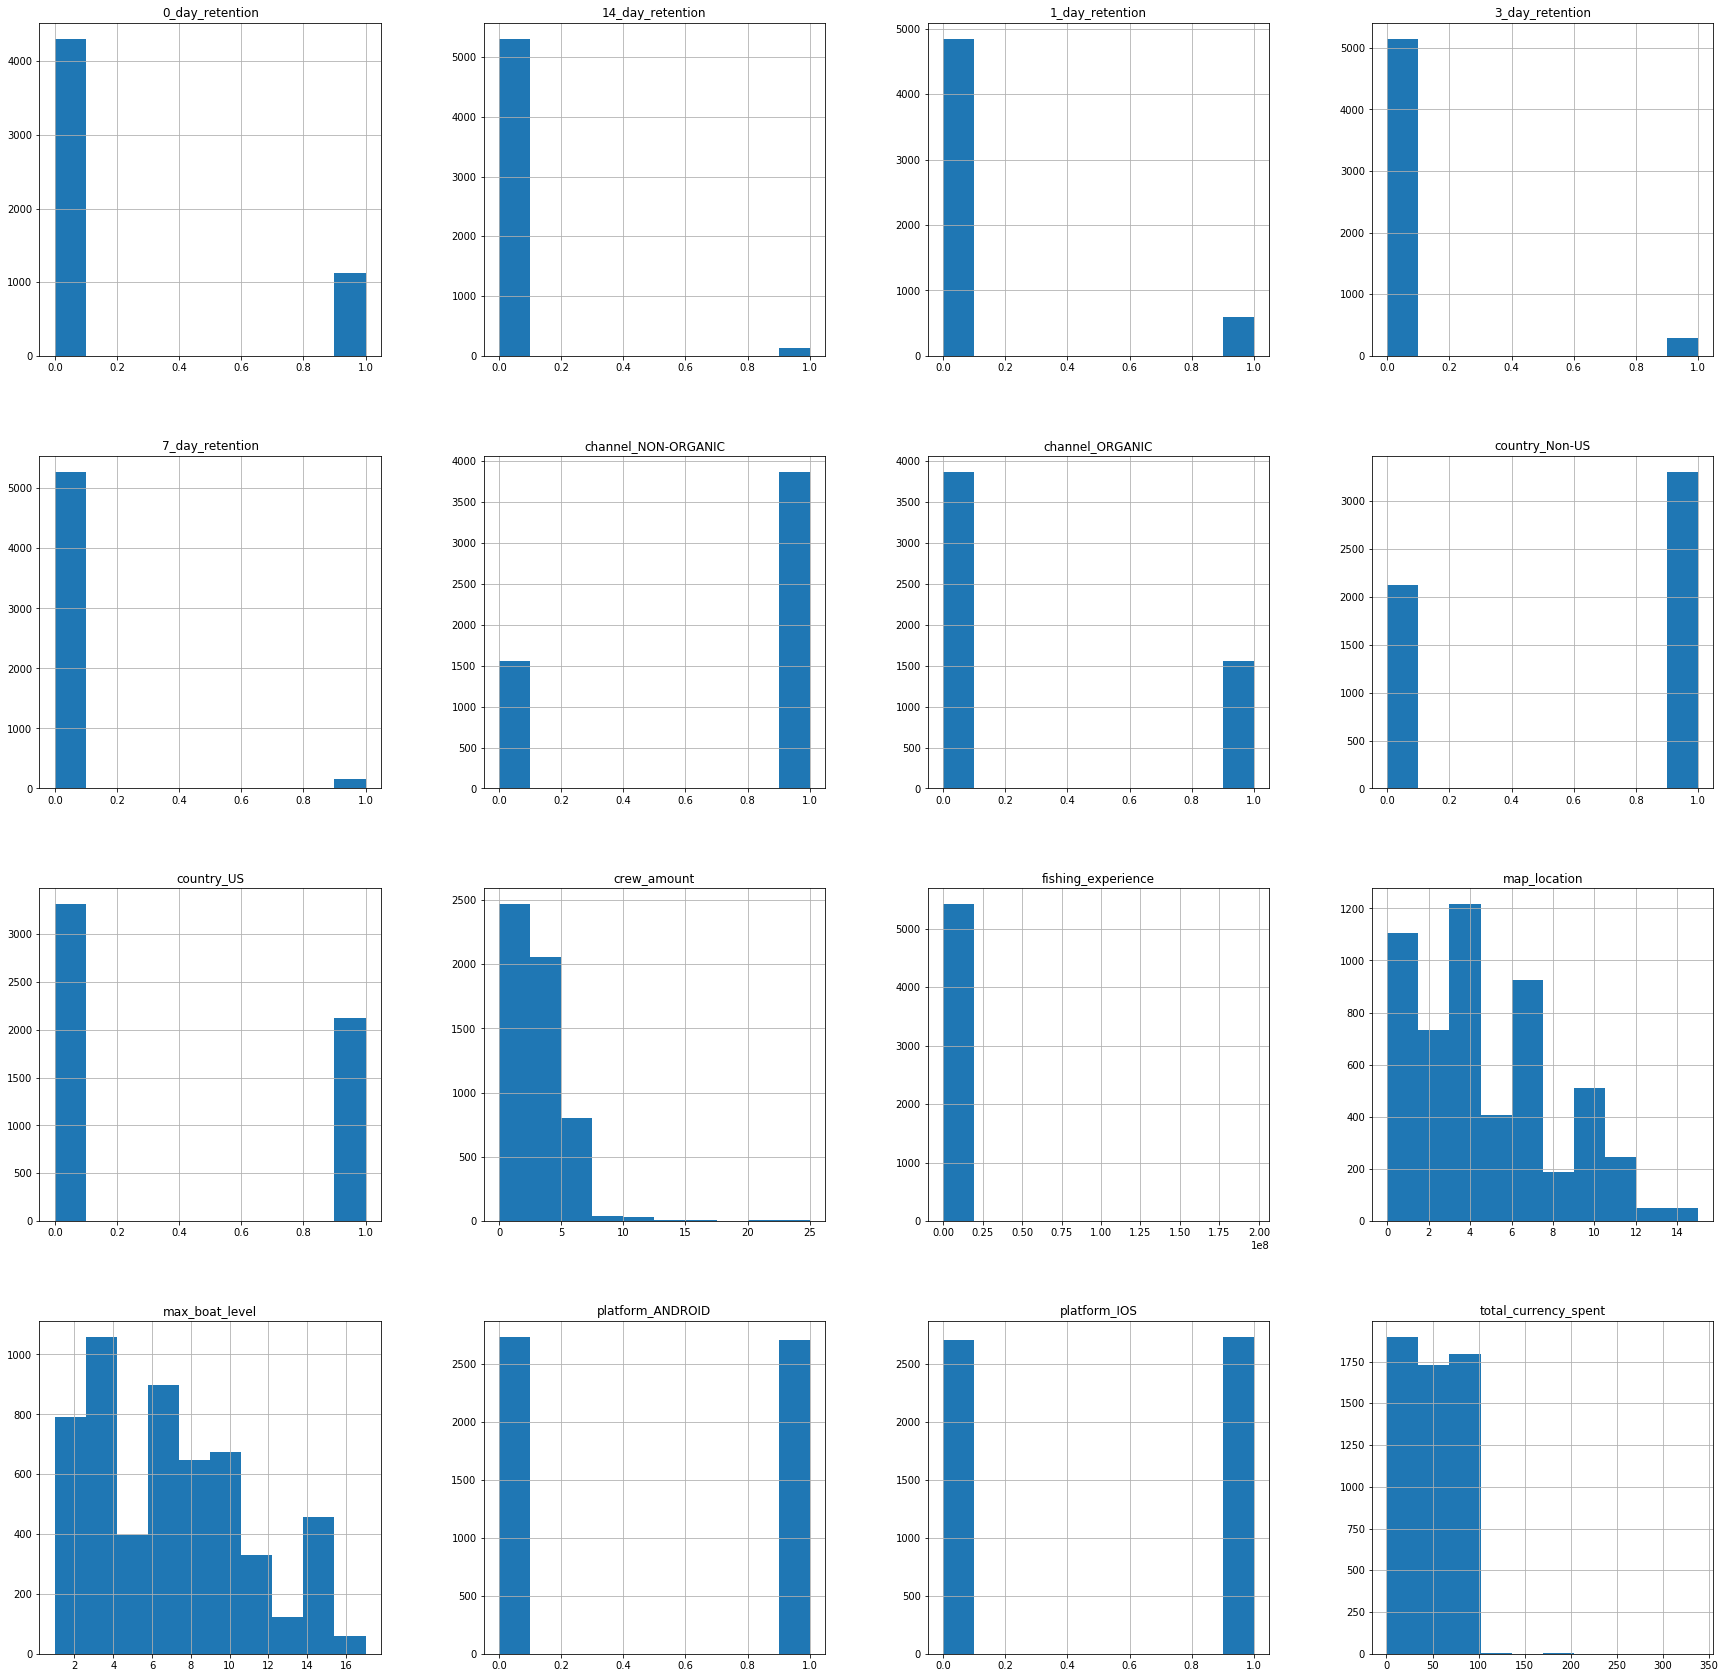

In [7]:
df_n[df_n.dtypes[(df_n.dtypes!="string")|(df_n.dtypes=="int64")].index.values].hist(figsize=[30,30])

### Remove outliers and scale
There are also several ways to transform numerical data so that it is normally distributed. Again, for simplicity we will simply use the scale method inside of scikit learn. Before doing that however, we need to remove outliers. For this we will just **remove those outside of 3 standard deviations**: 

In [8]:
df_n.describe()

,total_currency_spent,max_boat_level,fishing_experience,map_location,crew_amount,0_day_retention,1_day_retention,3_day_retention,7_day_retention,14_day_retention,channel_NON-ORGANIC,channel_ORGANIC,country_Non-US,country_US,platform_ANDROID,platform_IOS
count,5433.000000,5433.000000,5.433000e+03,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000,5433.000000
mean,50.597276,6.785570,2.444739e+05,4.573532,2.890852,0.207804,0.108412,0.053193,0.028529,0.023744,0.712866,0.287134,0.609424,0.390576,0.497331,0.502669
std,29.698655,3.892498,5.112838e+06,3.260445,2.214238,0.405773,0.310928,0.224440,0.166495,0.152264,0.452466,0.452466,0.487924,0.487924,0.500039,0.500039
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,3.000000,2.400000e+01,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,6.000000,3.380000e+02,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,76.000000,9.000000,2.409000e+03,7.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,338.000000,17.000000,1.968059e+08,15.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
from numpy import mean
from numpy import std
# calculate summary statistics

# All results will fall within this many standard deviations
STD_LIMIT = 3

for col in numerical_headers:
    data_mean, data_std = mean(df_n[col]), std(df_n[col])
    # identify outliers
    cut_off = data_std * STD_LIMIT
    lower, upper = data_mean - cut_off, data_mean + cut_off

    df_n = df_n[[x > lower and x < upper for x in df_n[col]]]

df_n.describe()

,total_currency_spent,max_boat_level,fishing_experience,map_location,crew_amount,0_day_retention,1_day_retention,3_day_retention,7_day_retention,14_day_retention,channel_NON-ORGANIC,channel_ORGANIC,country_Non-US,country_US,platform_ANDROID,platform_IOS
count,5347.000000,5347.000000,5.347000e+03,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000,5347.000000
mean,50.520105,6.657939,1.635293e+04,4.458014,2.725079,0.210772,0.109781,0.053862,0.027866,0.023191,0.714980,0.285020,0.612119,0.387881,0.500842,0.499158
std,29.256393,3.786566,2.058433e+05,3.150583,1.679628,0.407895,0.312646,0.225766,0.164604,0.150522,0.451466,0.451466,0.487313,0.487313,0.500046,0.500046
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,3.000000,2.300000e+01,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,6.000000,3.220000e+02,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,76.000000,9.000000,2.136500e+03,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,135.000000,16.000000,7.075427e+06,14.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Scale
Now that the data is much more evenly distributed, we should scale it so that all features hold equal weight to the model

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
# Scaling down both train and test data set
for num_header in numerical_headers:
    df_n[num_header + '_n'] = min_max_scaler.fit_transform(df_n[[num_header]])

df_n = df_n.drop(numerical_headers, axis='columns')
df_n.head()

,0_day_retention,1_day_retention,3_day_retention,7_day_retention,14_day_retention,channel_NON-ORGANIC,channel_ORGANIC,country_Non-US,country_US,platform_ANDROID,platform_IOS,total_currency_spent_n,max_boat_level_n,fishing_experience_n,map_location_n,crew_amount_n
0,0,0,1,0,0,1,0,1,0,1,0,0.365672,0.000000,0.000002,0.000000,0.500
3,0,0,0,0,0,1,0,1,0,1,0,0.029851,0.333333,0.000078,0.214286,0.500
4,1,0,0,0,0,1,0,1,0,1,0,0.156716,0.133333,0.000002,0.142857,0.375
5,0,0,0,0,0,1,0,1,0,1,0,0.037313,0.600000,0.000239,0.500000,0.125
6,0,0,0,0,0,1,0,0,1,0,1,0.134328,0.600000,0.000586,0.571429,0.875


In [11]:
### Drop duplicate headers (since its binary this is just these are just inverse of their counterparts)
duplicate_headers = ['channel_NON-ORGANIC', 'country_Non-US', 'platform_ANDROID']
df_n = df_n.drop(duplicate_headers, axis='columns')
df_n.head()

,0_day_retention,1_day_retention,3_day_retention,7_day_retention,14_day_retention,channel_ORGANIC,country_US,platform_IOS,total_currency_spent_n,max_boat_level_n,fishing_experience_n,map_location_n,crew_amount_n
0,0,0,1,0,0,0,0,0,0.365672,0.000000,0.000002,0.000000,0.500
3,0,0,0,0,0,0,0,0,0.029851,0.333333,0.000078,0.214286,0.500
4,1,0,0,0,0,0,0,0,0.156716,0.133333,0.000002,0.142857,0.375
5,0,0,0,0,0,0,0,0,0.037313,0.600000,0.000239,0.500000,0.125
6,0,0,0,0,0,0,1,1,0.134328,0.600000,0.000586,0.571429,0.875


## Splitting Data

### Split off targets from inputs
We can now split our data set into targets and inputs

In [12]:
inputs_n = df_n.drop(target_headers, axis='columns')
targets = df_n[target_headers]

inputs_n.head()

,channel_ORGANIC,country_US,platform_IOS,total_currency_spent_n,max_boat_level_n,fishing_experience_n,map_location_n,crew_amount_n
0,0,0,0,0.365672,0.000000,0.000002,0.000000,0.500
3,0,0,0,0.029851,0.333333,0.000078,0.214286,0.500
4,0,0,0,0.156716,0.133333,0.000002,0.142857,0.375
5,0,0,0,0.037313,0.600000,0.000239,0.500000,0.125
6,0,1,1,0.134328,0.600000,0.000586,0.571429,0.875


In [13]:
targets.head()

,14_day_retention,0_day_retention,3_day_retention,1_day_retention,7_day_retention
0,0,0,1,0,0
3,0,0,0,0,0
4,0,1,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0


In [14]:
# Change this to get other time periods of rententions
TARGET_COLUMN = '3_day_retention'

### Split off training from testing
We can now split our data set into a training and testing set by a specified percentage

In [15]:
TEST_SIZE = 0.2
train_x, test_x, train_y, test_y = train_test_split(inputs_n, targets[TARGET_COLUMN], test_size = TEST_SIZE)

In [16]:
train_x.columns

Index(['channel_ORGANIC', 'country_US', 'platform_IOS',
       'total_currency_spent_n', 'max_boat_level_n', 'fishing_experience_n',
       'map_location_n', 'crew_amount_n'],
      dtype='object')

## Building the model
There are two models that I think would be ideal for the specific task of determining which features are the best predictors of retention.

- Decision Tree / Random Forrest
- Multivariate Linear Regression

With each of thesee there is a mechanism for determining the strength of a feature. Decision trees visually show you using the "gini" impurity while multivariate regression provides t-statistic and p-values for the respective features. 

I personally am more familiar with the random tree and like to see things visually so I'll go with that. 

### Decision Tree

In [17]:
tree_model = tree.DecisionTreeClassifier()
tree_model = tree_model.fit(train_x, train_y)
tree_model.score(test_x, test_y)

0.914018691588785

In [18]:
graph = Source( tree.export_graphviz(tree_model, out_file=None, feature_names=train_x.columns, max_depth=3))
graph.format = 'png'
graph.render(TARGET_COLUMN + '_dtree' ,view=True)

'3_day_retention_dtree.png'

In [19]:
from sklearn.metrics import confusion_matrix
predicted_y = tree_model.predict(test_x)
cm = confusion_matrix(test_y, predicted_y)

In [20]:
cm

array([[978,  36],
       [ 56,   0]])

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [36]:
clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(train_x, train_y)
clf.feature_importances_

array([0.01062245, 0.0207015 , 0.02603883, 0.29520057, 0.11390617,
       0.29145463, 0.09874748, 0.14332838])

In [37]:
# https://scikit-learn.org/stable/modules/feature_selection.html
labeled_feature_importances = []
for i in range(len(clf.feature_importances_)):
    feature_importance = clf.feature_importances_[i]
    column = train_x.columns[i]
    
    labeled_feature_importances.append([column, feature_importance])

sorted_feature_importances = sorted(labeled_feature_importances,key=lambda x: -x[1])
sorted_feature_importances

# clf = ExtraTreesClassifier(n_estimators=10)
# [['total_currency_spent_n', 0.2952005720567495],
#  ['fishing_experience_n', 0.29145462806376343],
#  ['crew_amount_n', 0.14332838450362928],
#  ['max_boat_level_n', 0.11390616542276204],
#  ['map_location_n', 0.09874747669628925],
#  ['platform_IOS', 0.026038828109273503],
#  ['country_US', 0.020701499061549982],
#  ['channel_ORGANIC', 0.010622446085983103]]

# clf = ExtraTreesClassifier(n_estimators=20)
# [['total_currency_spent_n', 0.2980123270303389],
#  ['fishing_experience_n', 0.2835244851778749],
#  ['crew_amount_n', 0.14422546445674506],
#  ['max_boat_level_n', 0.11026973253682666],
#  ['map_location_n', 0.09567544205701309],
#  ['platform_IOS', 0.029975394164638607],
#  ['channel_ORGANIC', 0.021133654033663237],
#  ['country_US', 0.017183500542899608]]

# clf = ExtraTreesClassifier(n_estimators=50)
# [['total_currency_spent_n', 0.3120783345134442],
#  ['fishing_experience_n', 0.2763971621245534],
#  ['crew_amount_n', 0.14422988211045612],
#  ['max_boat_level_n', 0.1123294123435868],
#  ['map_location_n', 0.0943853623965093],
#  ['platform_IOS', 0.025637771524389907],
#  ['country_US', 0.022832681605768557],
#  ['channel_ORGANIC', 0.012109393381291775]]

# clf = ExtraTreesClassifier(n_estimators=100)
# [['total_currency_spent_n', 0.30683801546597894],
#  ['fishing_experience_n', 0.2812701183083532],
#  ['crew_amount_n', 0.14079145445962607],
#  ['max_boat_level_n', 0.11726545972234378],
#  ['map_location_n', 0.09763250489011815],
#  ['platform_IOS', 0.02426148051173549],
#  ['country_US', 0.018269353475528095],
#  ['channel_ORGANIC', 0.013671613166316248]]


[['total_currency_spent_n', 0.2952005720567495],
 ['fishing_experience_n', 0.29145462806376343],
 ['crew_amount_n', 0.14332838450362928],
 ['max_boat_level_n', 0.11390616542276204],
 ['map_location_n', 0.09874747669628925],
 ['platform_IOS', 0.026038828109273503],
 ['country_US', 0.020701499061549982],
 ['channel_ORGANIC', 0.010622446085983103]]

## Conculsion


### 1_day_rention decision tree
![1_day_retention_dtree](1_day_retention_dtree.png)

### 3_day_rention decision tree
![3_day_retention_dtree](3_day_retention_dtree.png)

### 7_day_rention decision tree
![7_day_retention_dtree](7_day_retention_dtree.png)

### 14_day_rention decision tree
![14_day_retention_dtree](14_day_retention_dtree.png)

From these trees (and according to this small sample size in this analysis) we can see that the following features were the most predictive:

- Max boat level
- Fishing experience
- Total currencty spent

As these branches in the tree led to the most cases where there was retention. 

### Final Thoughts
As I mentioned several times throughout this analysis. There is a lot that could be done to *drastically* improve these numbers. As I played around with the data I saw increases by doing the following:

- Imputing values instead of just throwing NULLS in the trash
- Making some numerical features that have categorical leanings into categorical features (but this might just be because of the lack of enough data) 
- Using a random forrest model instead of a random tree model (again only works with more data than I had for this example)
- Spending more time further transofrming features

All in all, I wanted to do a mix of the analysis but also setting this up in a way that it would still run with more data. 


### Next Steps
The next step, in my opinion, would be to work with the team to figure out which one of these "levers" we could pull. Here are some experiments that we could try based off of these conculsions drawn:

- Max boat level: Run an experiment to make it easier / faster to increase boat levels
- Fishing Experience: Run an experiment to increase fishing experience by sharing the app with a friend
- Total currency spent: Decrease the cost of iAP for some users and see if it encourages them to spend more currency and impacts retention


### Ending Questions
*How long did it take you to complete?*
This assingment all in all took me around 5 hours

*When looking at a new data set, describe your process towards understanding the data*
I think thats answered a lot in the text above

*What other data sets would have been valuable for your analysis*
- It would have been interesting to see more information on the "organic" vs "inorganic" side. I would be interested to know how granular that data goes and if we woulc see which ad campaigns people came from
- I would like to have session data into the future as well. I looked into how people who installed the app before-hand were retained during the live op period, but I would want to see if those people who *started* playing during the live op period were retained
- It would also have been helpful to know where the data I had was coming from and how reliable it was so that I could make a decision on what to do with nulls, missings, or incomplete data

*What reasonings could you think of on why we do deep dives on live events*
- They are a perfect chance to run experiments and learn more about the customer. Its an opportunity to pull a "lever" that makes a KPI move either up or down and over time with multiple of these you get a better understanding of the user base and how to keep them engaged
- Its a good opporunity to learn something new. Sometimes I imagine that during a live op the "hypothesis" that you're testing turns out to not be the biggest insight. Maybe people responded in a totally different way that gives an idea for a different focus for a future live op event
- You can line up multiple data sets at once. For example, while you might not be able to fully connect each user to an ad campaign that they came from, if you sync up the live op event with an ad campaign it might allow you to draw connections and get more rich insights

